<strong> Possible Casses </strong>

- Exploring Total number of cases over time (Mnfcture_wk) to see if there is a particular spike at any point in time. This could point to some issues in the manufacturing process/batch related to the weeks and help identify the root causes.
- The analysis above could be done in more granular levels, say per product type, issue type etc, topic category etc.
- We can come up with a time-series model to predict the number of parts required by using parts_ct. This can be done per region/country/parts_sent.
- We can look into the correlations between agent_tenure_indays and parts_ct, contact_manager_flg, repeat_ct etc. to understand where the new agents are struggling. We can add another dimension for topic category to see if some topics are harder to identify for the new agents than others.
- We can look into the correlation between the repeat_ct and contact_type to see if some communication channels are more effective than others.
- We can look into the correlation between diagnostics and repeat_ct to see if diagnostics are helpful to the agents. We can run a hypothesis testing to see if the effect is significant.
- We can look into the relation between the time after manufacturing till contact week and topic parts_sent to see what parts are failing when.
- We can look into if people are contacting the support right before their warranty expires.
- We can look into the correlation between topic_category and repeat_ct to see if some problem types especially lead to additional visits.

In [288]:
# Imports 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import plotly
import plotly.plotly as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

plotly.tools.set_credentials_file(username='mrbalikci', api_key='UOYflXmBJelkNxcCHA0y')

%matplotlib inline

In [289]:
# read the data with all default parameters 
df = pd.read_csv('data_set.csv', index_col='asst_id', encoding='utf-8', low_memory=False)

In [290]:
# data types and non-null counts 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 16664
Data columns (total 18 columns):
product_type           99980 non-null object
mnfture_wk             100000 non-null int64
contract_st            100000 non-null int64
contract_end           100000 non-null int64
contact_wk             100000 non-null int64
contact_type           99986 non-null object
issue_type             85958 non-null object
topic_category         66916 non-null object
parts_sent             54566 non-null object
repair_type            100000 non-null object
repeat_ct              100000 non-null int64
parts_ct               100000 non-null int64
agent_tenure_indays    99986 non-null float64
contact_manager_flg    100000 non-null int64
diagnostics            100000 non-null object
repeat_parts_sent      13346 non-null object
region                 99997 non-null object
country                89998 non-null object
dtypes: float64(1), int64(7), object(10)
memory usage: 14.5+ MB


In [291]:
# take care of missing values for numerical columns 
# replace NaNs with '-888'
df['agent_tenure_indays']=df['agent_tenure_indays'].fillna('-888')

In [292]:
# replace NaNs with 'Unknown' for object type columns
df = df.fillna('Unknown')

# VOICE and Voice can be combined as 'Voice'
df['contact_type']=df['contact_type'].str.replace('VOICE','Voice')

### Time Related Columns to DateTime format

In [293]:
# change type to string
df['mnfture_wk']=df['mnfture_wk'].astype(str)
df['contract_st']=df['contract_st'].astype(str)
df['contract_end']=df['contract_end'].astype(str)
df['contact_wk']=df['contact_wk'].astype(str)

# taking care of mnfture
df['mnfture_year'] = df['mnfture_wk'].str[0:4]
df['mnfture_week'] = df['mnfture_wk'].str[4:6]
df["mnfture_datetime"] = pd.to_datetime(df.mnfture_week.astype(str)+
                          df.mnfture_year.astype(str).add('-0') ,format='%W%Y-%w')

# taking care of contact year
df['contact_year'] = df['contact_wk'].str[0:4]
df['contact_week'] = df['contact_wk'].str[4:6]
df["contact_week_datetime"] = pd.to_datetime(df.contact_week.astype(str)+
                          df.contact_year.astype(str).add('-0') ,format='%W%Y-%w')

# taking care of contract end year
df['contract_year'] = df['contract_end'].str[0:4]
df['contract_week'] = df['contract_end'].str[4:6]
df["contract_end_datetime"] = pd.to_datetime(df.contract_week.astype(str)+
                          df.contract_year.astype(str).add('-0') ,format='%W%Y-%w')

# Data Insights

<strong>CASE 1 

* Exploring Total number of cases over time (Mnfcture_wk) to see if there is a particular spike at any point in time. This could point to some issues in the manufacturing process/batch related to the weeks and help identify the root causes.

* The analysis above could be done in more granular levels, say per product type, issue type etc, topic category etc. </strong>

### Number of Cases Over Time: Each Machine Sold

In [294]:
# get the total case of each machine sold
df_asst_id = df.reset_index()
df_asst_id = pd.DataFrame(df_asst_id.asst_id.value_counts()).reset_index()
df_asst_id = df_asst_id.rename(columns={'index':'asst_id', 'asst_id':'count'})
df_asst_id.head()

,asst_id,count
0,72568,46
1,5183,18
2,7715,14
3,18338,7
4,11152,6


<strong>Findings</strong>: It seems one machine sold 46 times so further analysis on this particular case will not be needed.

### Number of Cases Over Time: Manufactured

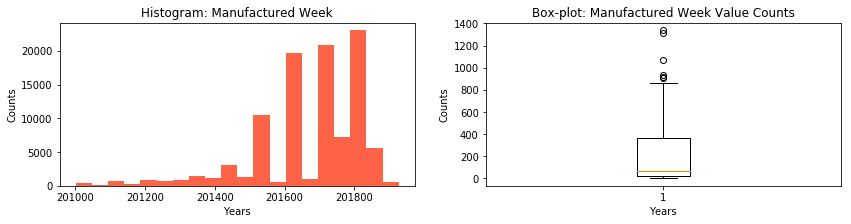

In [295]:
# change the type from object to numerical for mnfture_wk
df['mnfture_wk']=df['mnfture_wk'].astype(float)

# histogram for manufactured week
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,3))

ax1.hist(df.mnfture_wk, bins=20, color='tomato')
ax1.set_title('Histogram: Manufactured Week')
ax1.set_xlabel('Years')
ax1.set_ylabel('Counts')

ax2.boxplot(df['mnfture_wk'].value_counts())
ax2.set_title('Box-plot: Manufactured Week Value Counts')
ax2.set_xlabel('Years')
ax2.set_ylabel('Counts')

plt.show()

In [296]:
# Manufactured Week Related Statistical Analysis (box-plot)

print('mean {}'.format(df['mnfture_wk'].value_counts().mean()))
print('median {} '.format(df['mnfture_wk'].value_counts().median()))
print('max {}'.format(df['mnfture_wk'].value_counts().max()))
print('min {}'.format(df['mnfture_wk'].value_counts().min()))
print('Range {}'.format((df['mnfture_wk'].value_counts().max())-(df['mnfture_wk'].value_counts().min())))
print('25th Perc {}'.format(df['mnfture_wk'].value_counts().quantile(0.25)))
print('50th Perc {}'.format(df['mnfture_wk'].value_counts().quantile(0.5)))
print('75th Perc {}'.format(df['mnfture_wk'].value_counts().quantile(0.75)))
print('Variance {}'.format(df['mnfture_wk'].value_counts().var()))
print('Standard Deviation {}'.format(df['mnfture_wk'].value_counts().std()))

mean 201.2072434607646
median 64.0 
max 1340
min 1
Range 1339
25th Perc 23.0
50th Perc 64.0
75th Perc 364.0
Variance 60043.85817323293
Standard Deviation 245.038483045486


<strong> Findings I</strong>
* A quick analysis from the histogram graph shows that there are a spike of manufactured defects in some of 2016, 2017, and mainly 2018 years.
* The box-plot shows upper and lower quartiles as well as the median line which is below 200 for that number of cases related to the manufactured weeks.
* The outliers from the box-plot suggests that some of manufactured weeks got big reporting numbers in production defects/issues/process/batch related.

In [297]:
# In this block, sort values based on value counts of manufacture week.
# It will help us to determine the most issue related manufacture related weeks. 

df_count_mnfture_wk = pd.DataFrame(df.mnfture_datetime.value_counts())
df_count_mnfture_wk = df_count_mnfture_wk.rename(columns={'mnfture_datetime':'count'}).reset_index()
df_count_mnfture_wk = df_count_mnfture_wk.rename(columns={'index':'mnfture_datetime'})
df_count_mnfture_wk['percent']= round((df_count_mnfture_wk['count']/df_count_mnfture_wk['count'].sum())*100,4)
df_count_mnfture_wk.head()

,mnfture_datetime,count,percent
0,2018-09-30,1340,1.340
1,2018-07-01,1312,1.312
2,2018-06-24,1072,1.072
3,2018-01-07,1053,1.053
4,2018-04-01,938,0.938


In [298]:
# Bar-Chart for Manufactured vs Cases Over Time

x=df_count_mnfture_wk['mnfture_datetime']
y=df_count_mnfture_wk['count'] 

data = [
    go.Bar(
        x=x, # assign x as the dataframe column 'x'
        y=y
    )
]

layout = go.Layout(
    barmode='stack',
    title='Manufactured vs Cases Over Time'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

C:\Users\mrbal\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



<strong>Findings II</strong>:
* As seen from the bar-chart there is positive correlation of cases all the way up to 2018 if 2019 cases are ignored. 

* There is a spike in 2018 in terms of number of cases rising. Perhaps, this could point to some of the issues in the manufacturing process/batch related to the weeks and help identify the root causes.
* The analysis above gave us some idea what manufactured years and weeks got higher cases. By using this analysis, we can focus on what particular product type, repair type, parts, etc in more details as part of the risk assessment for the future cost related operations.

### Number of Cases Over Time: Product Type



In [299]:
# grab data for product type and number of cases over time
df_count_product_type = pd.DataFrame(df.product_type.value_counts(normalize=True)).reset_index()
df_count_product_type = df_count_product_type.rename(columns={'product_type':'count'})
df_count_product_type = df_count_product_type.rename(columns={'index':'product_type'})
df_count_product_type.head()

,product_type,count
0,Laptops,0.73052
1,Desktops,0.23601
2,Other Electronics,0.03327
3,Unknown,0.00020


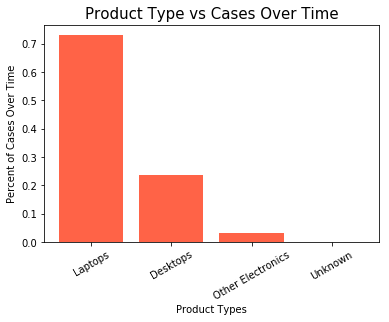

In [300]:
# create a bar chart of the findings 

labels_product_type=df_count_product_type['product_type']
values_product_type=df_count_product_type['count']

def product_type_bar_plot():
    # this is for plotting purpose
    index = np.arange(len(labels_product_type))
    plt.bar(index, values_product_type, color='tomato')
    plt.xlabel('Product Types', fontsize=10)
    plt.ylabel('Percent of Cases Over Time', fontsize=10)
    plt.xticks(index, labels_product_type, fontsize=10, rotation=30)
    plt.title('Product Type vs Cases Over Time', fontsize=15)
    plt.show()
product_type_bar_plot()

In [301]:
# find manufactured weeks vs product types with higher reporting numbers 
df_laptop_most = pd.DataFrame(df.groupby(['mnfture_wk','product_type']).mnfture_wk.count())
df_laptop_most = df_laptop_most.rename(columns={'mnfture_wk':'count'})
df_laptop_most = df_laptop_most.sort_values('count', ascending=False)
df_laptop_most.head(10)

,,count
mnfture_wk,product_type,
201826.0,Laptops,1094
201825.0,Laptops,892
201813.0,Laptops,784
201839.0,Laptops,772
201739.0,Laptops,752
201808.0,Laptops,676
201821.0,Laptops,651
201744.0,Laptops,648
201816.0,Laptops,642


<strong>Findings</strong>: 
* As seen from the bar chart laptops with 73% reported compared with other product types for issues if we ignore contact week after the contract ends.
* The above table is grouped by 'mnfture_wk' and 'product_type' and aggregated by 'count' to see what manufactured week most product type was reported. As seen from the table, manufactured weeks 26, 25, 13, 39 of 2018 reporting more numbers of laptops. 

### Number of Cases Over Time: Repair Type

In [302]:
# grab data for repair type and number of cases over time

df_count_repair_type = pd.DataFrame(df.repair_type.value_counts(normalize=True)).reset_index()
df_count_repair_type = df_count_repair_type.rename(columns={'repair_type':'count'})
df_count_repair_type = df_count_repair_type.rename(columns={'index':'repair_type'})
df_count_repair_type.head()

,repair_type,count
0,Hard,0.59495
1,Soft,0.40505


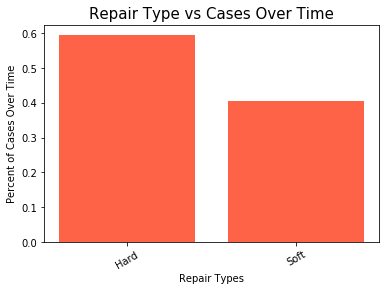

In [303]:
# create a bar chart of the findings 

labels_repair_type=df_count_repair_type['repair_type']
values_repair_type=df_count_repair_type['count']

def repair_type_bar_plot():
    # this is for plotting purpose
    index = np.arange(len(labels_repair_type))
    plt.bar(index, values_repair_type, color='tomato')
    plt.xlabel('Repair Types', fontsize=10)
    plt.ylabel('Percent of Cases Over Time', fontsize=10)
    plt.xticks(index, labels_repair_type, fontsize=10, rotation=30)
    plt.title('Repair Type vs Cases Over Time', fontsize=15)
    plt.show()
repair_type_bar_plot()

In [304]:
# find manufactured weeks - product types vs repair types with higher reporting numbers 
df_laptop_repair_most = pd.DataFrame(df.groupby(['mnfture_wk','product_type', 'repair_type']).mnfture_wk.count())
df_laptop_repair_most = df_laptop_repair_most.rename(columns={'mnfture_wk':'count'})
df_laptop_repair_most = df_laptop_repair_most.sort_values('count', ascending=False)
df_laptop_repair_most.head(10)

count
mnfture_wk product_type repair_type       
201839.0   Laptops      Soft           597
201826.0   Laptops      Hard           557
                        Soft           537
201813.0   Laptops      Hard           532
201825.0   Laptops      Hard           505
201626.0   Laptops      Hard           486
201739.0   Laptops      Hard           476
201816.0   Laptops      Hard           464
201625.0   Laptops      Hard           459
201520.0   Laptops      Hard           439

<strong>Findings</strong>:
* Approximately 59% of issues are related to hard-ware problems.
* The table above is grouped by 'mnfture_wk','product_type', and 'repair_type' to determine what manufactured week most repair type was reported along with product type. 
* As seen from this table, manufactured week 39, 26, 13, 25 were top reported with laptops as prduct type with software and hardware issues counts. 

### Number of Cases Over Time: Parts Sent

In [305]:
# filtering data 
df_count_parts_sent = pd.DataFrame(df.parts_sent.value_counts(normalize=True)).reset_index()
df_count_parts_sent = df_count_parts_sent.rename(columns={'parts_sent':'percent'})
df_count_parts_sent = df_count_parts_sent.loc[df_count_parts_sent['percent'] >0.003,:]
df_count_parts_sent = df_count_parts_sent.rename(columns={'index':'parts_sent'})
# df_count_parts_sent = df_count_parts_sent.iloc[1:] # 45% 'unknown' is dropped
df_count_parts_sent.head()

,parts_sent,percent
0,Unknown,0.45434
1,Hard Drive,0.04504
2,"Motherboard, Documentation",0.04405
3,LCD Panel,0.03022
4,Keyboard,0.02981


In [306]:
# plot the data by plotly

x=df_count_parts_sent['parts_sent']
y=df_count_parts_sent['percent'] 

data = [
    go.Bar(
        x=x, # assign x as the dataframe column 'x'
        y=y
    )
]

layout = go.Layout(
    barmode='stack',
    title='Parts Sent vs Cases Over Time'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

In [307]:
# find manufactured weeks - product types-repair types vs parts sent with higher reporting numbers 
df_laptop_repair_parts_most = pd.DataFrame(df.groupby(['mnfture_wk',
                                                       'product_type', 
                                                       'repair_type', 
                                                       'parts_sent']).mnfture_wk.count())
df_laptop_repair_parts_most = df_laptop_repair_parts_most.rename(columns={'mnfture_wk':'count'})
df_laptop_repair_parts_most = df_laptop_repair_parts_most.sort_values('count', ascending=False).reset_index()
df_laptop_repair_parts_most.head(10)

,mnfture_wk,product_type,repair_type,parts_sent,count
0,201839.0,Laptops,Soft,Unknown,597
1,201826.0,Laptops,Soft,Unknown,537
2,201839.0,Desktops,Soft,Unknown,414
3,201825.0,Laptops,Soft,Unknown,387
4,201832.0,Laptops,Soft,Unknown,362
5,201838.0,Laptops,Soft,Unknown,339
6,201834.0,Laptops,Soft,Unknown,337
7,201831.0,Laptops,Soft,Unknown,292
8,201739.0,Laptops,Soft,Unknown,276
9,201836.0,Laptops,Soft,Unknown,275


In [308]:
# find manufactured weeks - product types vs repair types with higher reporting numbers without 'Unknown'

df_laptop_repair_parts_most = df_laptop_repair_parts_most.loc[df_laptop_repair_parts_most['parts_sent'] != 'Unknown',:]
df_laptop_repair_parts_most.head(10)

,mnfture_wk,product_type,repair_type,parts_sent,count
90,201626.0,Laptops,Hard,"Adapter, AC",110
92,201816.0,Laptops,Hard,LCD Panel,109
105,201819.0,Laptops,Hard,LCD Panel,93
109,201824.0,Laptops,Hard,LCD Panel,91
132,201823.0,Laptops,Hard,LCD Panel,78
143,201820.0,Laptops,Hard,LCD Panel,72
148,201520.0,Laptops,Hard,Miscellaneous,71
191,201613.0,Laptops,Hard,LCD Panel,57
195,201523.0,Laptops,Hard,Miscellaneous,56
197,201445.0,Laptops,Hard,Chassis,56


<strong>Findings</strong>:
* Hard Drive, Motherboard, LCD Panel are top 3 items sent more and more compared to the other parts over time
* Keep that in mind 45% of the parts sent over time is 'unknown' and they are all related laptops-software from manufactured weeks 39, 26, 25, 32 of 2018 for top 5. 
* After filtering 'Unkown' from the table, we can see that for 2018 with weeks 16, 19, 24, and 23 leading top numbers for laptop-hardware and LCD Panel. Only week 26 of 2016 got a higher number for Adapter, AC as number 1 in the list. 
* So, software related parts marked as 'Unknown', perhaps, this type of part was not ment to be sent since it is software related issue. 
* In other hands, hardware related issuses can give us some ideas year of 2018 with marked weeks should be inspected at its production level and LCD Panels could be the top one to focus. 
* Please note, these tables can be expended for other type of parts for further inspection. 

### Number of Cases Over Time: Contact Type

In [309]:
# data for number of contact type in percents

df_count_contact_type = pd.DataFrame(df.contact_type.value_counts(normalize=True)).reset_index()
df_count_contact_type = df_count_contact_type.rename(columns={'contact_type':'percent'})
df_count_contact_type = df_count_contact_type.rename(columns={'index':'contact_type'})
df_count_contact_type

,contact_type,percent
0,Voice,0.84162
1,CHAT,0.14425
2,EMAIL,0.01281
3,Unknown,0.00132


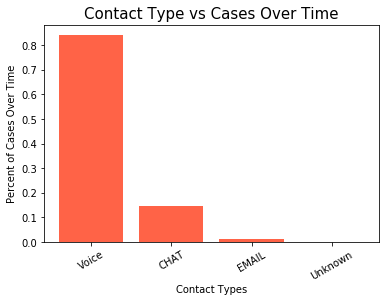

In [310]:
# create a bar chart of the table df_count_contact_type

labels_contact_type=df_count_contact_type['contact_type']
values_contact_type=df_count_contact_type['percent']

def contact_type_bar_plot():
    # this is for plotting purpose
    index = np.arange(len(labels_contact_type))
    plt.bar(index, values_contact_type, color='tomato')
    plt.xlabel('Contact Types', fontsize=10)
    plt.ylabel('Percent of Cases Over Time', fontsize=10)
    plt.xticks(index, labels_contact_type, fontsize=10, rotation=30)
    plt.title('Contact Type vs Cases Over Time', fontsize=15)
    plt.show()
contact_type_bar_plot()

In [311]:
# find manufactured weeks - product types-repair types-parts_sent vs contact_type with higher reporting numbers 
df_laptop_repair_parts_contact_most = pd.DataFrame(df.groupby(['mnfture_wk',
                                                               'product_type', 
                                                               'repair_type', 
                                                               'parts_sent',
                                                               'contact_type']).mnfture_wk.count())
df_laptop_repair_parts_contact_most = df_laptop_repair_parts_contact_most.rename(columns={'mnfture_wk':'count'})
df_laptop_repair_parts_contact_most = df_laptop_repair_parts_contact_most.sort_values('count', ascending=False)
df_laptop_repair_parts_contact_most.head(10)

,,,,,count
mnfture_wk,product_type,repair_type,parts_sent,contact_type,
201839.0,Laptops,Soft,Unknown,Voice,493
201826.0,Laptops,Soft,Unknown,Voice,491
201839.0,Desktops,Soft,Unknown,Voice,361
201825.0,Laptops,Soft,Unknown,Voice,345
201832.0,Laptops,Soft,Unknown,Voice,336
201838.0,Laptops,Soft,Unknown,Voice,291
201834.0,Laptops,Soft,Unknown,Voice,281
201831.0,Laptops,Soft,Unknown,Voice,258
201739.0,Laptops,Soft,Unknown,Voice,258


<strong>Findings</strong>:
* Voice is preferred as the main source of contact for the issues reporting with 84% rate.
* As seen from the table above, contact_type voice seems to be a first choice for reporting an issue for the top manufactured weeks.
* In the further analysis, we can inspect if the contact type 'voice' is one of the good choice for resolving issue if it is used by the customers. 

### Number of Cases Over Time: Topic Category

In [312]:
# data for the number of topic category normalized (in percents)
df_count_topic_category = pd.DataFrame(df.topic_category.value_counts(normalize=True)).reset_index()
df_count_topic_category = df_count_topic_category.rename(columns={'topic_category':'percent'})
df_count_topic_category = df_count_topic_category.rename(columns={'index':'topic_category'})
df_count_topic_category.head(10)

,topic_category,percent
0,Unknown,0.33084
1,Booting,0.15343
2,LCD/Monitor,0.05452
3,Call Logs,0.04837
4,General Queries,0.04141
5,Hard Drive,0.03534
6,System Performance,0.03459
7,Internet/Wireless,0.03093
8,Keyboard,0.02666
9,Battery,0.02478


In [313]:
# plot the data for table df_count_topic_category

x=df_count_topic_category['topic_category']
y=df_count_topic_category['percent'] 

data = [
    go.Bar(
        x=x,
        y=y
    )
]

layout = go.Layout(
    barmode='stack',
    title='Topic Category vs Number of Cases Over Time'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

In [314]:
# find manufactured weeks - product types-repair types-parts_sent vs contact_type with higher reporting numbers 
df_laptop_repair_parts_contact_topic_category_most = pd.DataFrame(df.groupby(['mnfture_wk',
                                                               'product_type', 
                                                               'repair_type', 
                                                               'parts_sent',
                                                               'contact_type',
                                                               'topic_category']).mnfture_wk.count())
df_laptop_repair_parts_contact_topic_category_most = df_laptop_repair_parts_contact_topic_category_most.rename(columns={'mnfture_wk':'count'})
df_laptop_repair_parts_contact_topic_category_most = df_laptop_repair_parts_contact_topic_category_most.sort_values('count', ascending=False)
df_laptop_repair_parts_contact_topic_category_most.head(10)

,,,,,,count
mnfture_wk,product_type,repair_type,parts_sent,contact_type,topic_category,
201826.0,Laptops,Soft,Unknown,Voice,Unknown,124
201839.0,Laptops,Soft,Unknown,Voice,Unknown,113
201626.0,Laptops,Hard,"Adapter, AC",Voice,Unknown,110
201816.0,Laptops,Hard,LCD Panel,Voice,Unknown,104
201819.0,Laptops,Hard,LCD Panel,Voice,Unknown,92
201832.0,Laptops,Soft,Unknown,Voice,Unknown,88
201839.0,Desktops,Soft,Unknown,Voice,Unknown,86
201825.0,Laptops,Soft,Unknown,Voice,Unknown,84
201824.0,Laptops,Hard,LCD Panel,Voice,Unknown,82


In [315]:
# find manufactured weeks - product types vs repair types with higher reporting numbers without 'Unknown'
df_laptop_repair_parts_contact_topic_category_most = df_laptop_repair_parts_contact_topic_category_most.reset_index()
df_laptop_repair_parts_contact_topic_category_most = df_laptop_repair_parts_contact_topic_category_most.\
                            loc[df_laptop_repair_parts_contact_topic_category_most['topic_category'] != 'Unknown',:]
df_laptop_repair_parts_contact_topic_category_most.head(10)

,mnfture_wk,product_type,repair_type,parts_sent,contact_type,topic_category,count
10,201826.0,Laptops,Soft,Unknown,Voice,Booting,73
16,201826.0,Laptops,Soft,Unknown,Voice,OS,62
20,201839.0,Laptops,Soft,Unknown,Voice,Initial Setup,60
29,201734.0,Laptops,Soft,Unknown,Voice,General Queries,53
31,201839.0,Desktops,Soft,Unknown,Voice,Microsoft Office,52
32,201839.0,Laptops,Soft,Unknown,Voice,Microsoft Office,51
35,201813.0,Laptops,Soft,Unknown,Voice,Booting,48
36,201825.0,Laptops,Soft,Unknown,Voice,Booting,48
40,201814.0,Laptops,Soft,Unknown,Voice,Booting,47
44,201808.0,Laptops,Soft,Unknown,Voice,Booting,46


<strong>Findings</strong>:
* From 'df_count_topic_category' table Booting, LCD/Monitor, Call Logs are top 3 topic categories that are classified as problem by tech support aloing 33% as marked 'Unkown'
* From 'df_laptop_repair_parts_contact_topic_category_most' table top topic-categories for manufactured weeks and years are booting, OS, Initial Setup, General Queries, and MS Office. 
* So far we can say that week 26 of 2018 with laptop was giving more software issues so 'Unknown' part mostlikely no parts sent for booting and customer contacted to the Dell Tech support with Voice. So that particular week and close dates needs to be inspected for laptops with software-booting issues likely. 

### Number of Cases Over Time: Region

In [316]:
# gather the data
df_region_country = pd.DataFrame(df.groupby(['region','country']).agg({'region':'count', 'country':'count'}))
df_region_country = df_region_country.rename(columns={'region':'region_count', 'country':'country_count'}).reset_index()
df_region_country.head()

,region,country,region_count,country_count
0,Hogwarts,Diagon Alley,4,4
1,Hogwarts,Gryffindor,17,17
2,Hogwarts,Hog's Head Inn,3,3
3,Hogwarts,Honeyduke's,24,24
4,Hogwarts,Hufflepuff,52,52


<strong>Conclusion</strong>:
Assumed this data is a mock up data so region and country alignment does not make any sense to analyze

### Number of Cases over Time: Product and Repair Types

In [317]:
# Merge product type and repair type and aggregate it based on manufactured week count

df_repair_type_cases_over_time = pd.DataFrame(df.groupby(['product_type','repair_type']).mnfture_wk.count()).sort_values('mnfture_wk', ascending=False)
df_repair_type_cases_over_time = df_repair_type_cases_over_time.rename(columns={'mnfture_wk':'number_of_cases'}).reset_index()
df_repair_type_cases_over_time["product_repair_type"] = df_repair_type_cases_over_time["product_type"].map(str) +"-"+ df_repair_type_cases_over_time["repair_type"]
df_repair_type_cases_over_time['prc_of_cases'] = (df_repair_type_cases_over_time['number_of_cases']/(df_repair_type_cases_over_time['number_of_cases'].sum()))*100
df_repair_type_cases_over_time.head(10)

,product_type,repair_type,number_of_cases,product_repair_type,prc_of_cases
0,Laptops,Hard,45897,Laptops-Hard,45.897
1,Laptops,Soft,27155,Laptops-Soft,27.155
2,Desktops,Soft,12047,Desktops-Soft,12.047
3,Desktops,Hard,11554,Desktops-Hard,11.554
4,Other Electronics,Hard,2043,Other Electronics-Hard,2.043
5,Other Electronics,Soft,1284,Other Electronics-Soft,1.284
6,Unknown,Soft,19,Unknown-Soft,0.019
7,Unknown,Hard,1,Unknown-Hard,0.001


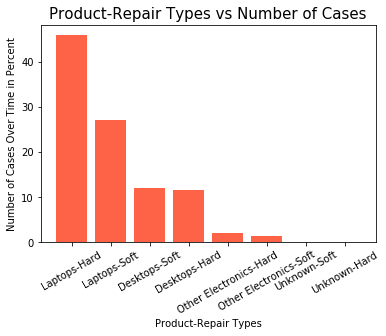

In [318]:
# create a bar chart of the findings 

labels_product_repair_type=df_repair_type_cases_over_time['product_repair_type']
values_product_repair_type=df_repair_type_cases_over_time['prc_of_cases']

def product_repair_type_bar_plot():
    # this is for plotting purpose
    index = np.arange(len(labels_product_repair_type))
    plt.bar(index, values_product_repair_type, color='tomato')
    plt.xlabel('Product-Repair Types', fontsize=10)
    plt.ylabel('Number of Cases Over Time in Percent', fontsize=10)
    plt.xticks(index, labels_product_repair_type, fontsize=10, rotation=30)
    plt.title('Product-Repair Types vs Number of Cases', fontsize=15)
    plt.show()
product_repair_type_bar_plot()

<strong>Findings</strong>:
* In 'df_repair_type_cases_over_time' table 'product_type' and 'repair_type' grouped and aggregated by 'mnfture_wk' 
* It shows that Product type 'Laptop' and Repair Type 'Hard' issues seem the most reported overall with ~46%. 
* Please note, this analysis is done to see overall cases for product-repair types not confused with top product-repair types with most reported manufactured weeks. 
* This analysis tells us, parts related to the laptops tends to fail before or after the contract ends. 

<strong> CASE 2
* We can look into the correlations between agent_tenure_indays and parts_ct, contact_manager_flg, repeat_ct etc. to understand where the new agent"s are struggling. We can add another dimension for topic category to see if some topics are harder to identify for the new agents than others. </strong>

### Correlations: Agent Tenure Indays vs Contact Manager Flg

In [319]:
# change the type from object to numerical 
df['agent_tenure_indays']=df['agent_tenure_indays'].astype(float)

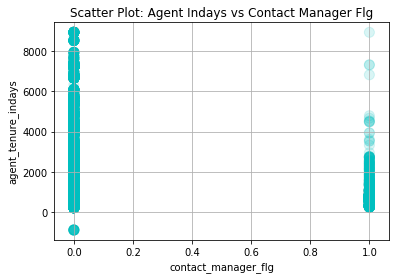

In [320]:
# plot the additional parts sent vs contact type 

x = df.contact_manager_flg
y = df.agent_tenure_indays

# circle sizes based on number of additional visits
area = 100 + df.contact_manager_flg 

plt.scatter(x, y, s=area, c='c', alpha=0.15)
# plt.legend(handles=[voice, chat, email, unknown])
plt.title('Scatter Plot: Agent Indays vs Contact Manager Flg')
plt.xlabel('contact_manager_flg')
plt.ylabel('agent_tenure_indays')
plt.grid()
plt.show()

In [321]:
# number of unique agents, assuming every agent got different hiring dates
agent_unique = len(df.agent_tenure_indays.unique())
print(f"number of agents is {agent_unique}")

# filter data for agents contacted to their manager more than one
df['agent_tenure_indays']=df['agent_tenure_indays'].astype(float)
df_agent_to_contact_mngr = df[['agent_tenure_indays','contact_manager_flg']].reset_index()
df_agent_to_contact_mngr = df_agent_to_contact_mngr.loc[df_agent_to_contact_mngr['contact_manager_flg']==1,:]
df_agent_to_contact_mngr = df_agent_to_contact_mngr.loc[df_agent_to_contact_mngr['agent_tenure_indays']<=1018,:]
agent_unique_less_exp = len(df_agent_to_contact_mngr.agent_tenure_indays.unique())
print(f"number of agents got experience less than 1018 days is {agent_unique_less_exp}")

number of agents is 1045
number of agents got experience less than 1018 days is 160


In [322]:
# find the percent of number of agents who has experience less than 1018 days or equal.

prc_mngr = round((agent_unique_less_exp/agent_unique)*100,2)
print(f"{prc_mngr}% of agents who has experience <= 1018 days tends to get help from their superiors.")

15.31% of agents who has experience <= 1018 days tends to get help from their superiors.


<strong>Findings</strong>:

* 'Scatter Plot: Agent Indays vs Contact Manager Flg' graph 'contact_manager_flg' axis where x = 1 which represent 'manager contacted' shows more inexperienced agents took the matter to their superiors.

* While y axis icreasing for x = 1 the color of circle is fading which is supporting that finding. 

* From some math, we can see that 15.31% of agents who got experience <= 1018 days tend to get help from their superiors.

### Correlations: Agent Tenure Indays vs Additional Visits

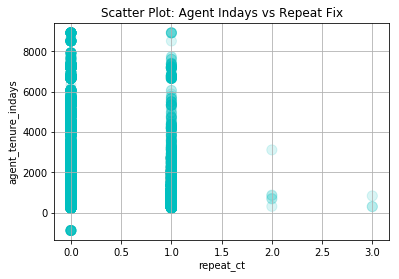

In [323]:
# scatter plot for agent tenure indays vs additional visits

x = df.repeat_ct
y = df.agent_tenure_indays

# circle sizes based on number of repeat fixes
area = 100 + df.repeat_ct 

plt.scatter(x, y, s=area, c='c', alpha=0.15)
# plt.legend(handles=[voice, chat, email, unknown])
plt.title('Scatter Plot: Agent Indays vs Repeat Fix')
plt.xlabel('repeat_ct')
plt.ylabel('agent_tenure_indays')
plt.grid()
plt.show()

In [324]:
# filter data for agents did additional visits more than zero

df['agent_tenure_indays']=df['agent_tenure_indays'].astype(float)
df_agent_repeat_ct = df[['agent_tenure_indays', 'repeat_ct']]
df_agent_repeat_ct = df_agent_repeat_ct.loc[df_agent_repeat_ct['repeat_ct']>0,:]
df_agent_repeat_ct.head()

,agent_tenure_indays,repeat_ct
asst_id,,
6,1757.0,1
19,1250.0,1
25,720.0,1
38,767.0,1
39,1018.0,1


In [325]:
# number of unique agents, assuming every agent got different hiring dates
agent_unique = len(df.agent_tenure_indays.unique())
print(f"number of agents is {agent_unique}")

# filter data for agents contacted to their manager more than one
df['agent_tenure_indays']=df['agent_tenure_indays'].astype(float)
df_agent_repeat_ct = df[['agent_tenure_indays', 'repeat_ct']]
df_agent_repeat_ct = df_agent_repeat_ct.loc[df_agent_repeat_ct['repeat_ct']>0,:]
df_agent_repeat_ct = df_agent_repeat_ct.loc[df_agent_repeat_ct['agent_tenure_indays']<=1018,:]
agent_unique_less_exp_2 = len(df_agent_repeat_ct.agent_tenure_indays.unique())
print(f"number of agents got experience less than 1018 days is {agent_unique_less_exp_2}")

number of agents is 1045
number of agents got experience less than 1018 days is 265


In [326]:
# find the percent of number of agents who has experience less than 1018 days or equal.

prc_repeat = round((agent_unique_less_exp_2/agent_unique)*100,2)
print(f"{prc_repeat}% of agents who has experience <= 1018 days tends to do additional visits")

25.36% of agents who has experience <= 1018 days tends to do additional visits


In [327]:
df_agent_repeat_mnfture_most = df.loc[df.repeat_ct > 0, :]
df_agent_repeat_mnfture_most = pd.DataFrame(df.groupby(['agent_tenure_indays',
                                                               'mnfture_wk', 
                                                                ]).repeat_ct.count())
df_agent_repeat_mnfture_most = df_agent_repeat_mnfture_most.rename(columns={'repeat_ct':'repeat_count'})
df_agent_repeat_mnfture_most = df_agent_repeat_mnfture_most.sort_values('repeat_count', ascending=False)
df_agent_repeat_mnfture_most.head(20)

repeat_count
agent_tenure_indays mnfture_wk              
1018.0              201520.0             402
                    201613.0             334
                    201523.0             280
                    201626.0             280
                    201816.0             274
                    201612.0             240
                    201622.0             236
                    201615.0             223
                    201524.0             216
                    201616.0             201
                    201625.0             201
                    201720.0             184
                    201819.0             183
                    201722.0             178
                    201824.0             166
                    201519.0             159
                    201628.0             158
                    201713.0             154
                    201725.0             153
                    201813.0             152

<strong>Findings</strong>:
* 'Scatter Plot: Agent Indays vs Repeat Fix' x-axis represents number of repeat fixes. y-axis represents agents in-days. Since we ignore x=0, for other x values y-values are fading when y increases. Especially x=2, and x = 3 shows more inexperienced agents additional visits. 

* From this observation, we can say that more additional visits were made by more inexperienced tech support comparing experienced ones.

* 'df_agent_repeat_mnfture_most' table is grouped by 'agent_tenure_indays', 'mnfture_wk' and aggregated by repeat_ct which additional visits taken by agent to fix the problem.
* Additionally, if we have a better data since this one is mock-up, it could be a better practice to keep inexperienced agents from the top production related most manufactured weeks if the same patterns found.

* Also from math, 25.36% of agents who has experience <= 1018 days tends to do additional visits. Assuming 1018 and below as inexperienced. 

### Correlations: Agent Tenure Indays vs Parts Sent

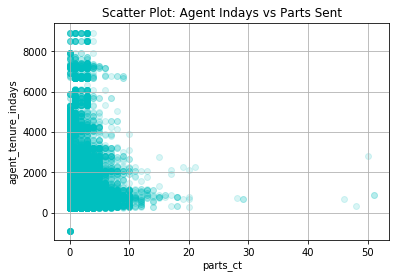

In [328]:
# scatter plot for agent tenure indays vs additional visits

x = df.parts_ct
y = df.agent_tenure_indays

plt.scatter(x, y, c='c', alpha=0.15)
plt.title('Scatter Plot: Agent Indays vs Parts Sent')
plt.xlabel('parts_ct')
plt.ylabel('agent_tenure_indays')
plt.grid()
plt.show()

In [329]:
# filter data for agents who has experience <= 1018 days and who did send parts more than 1

df['agent_tenure_indays']=df['agent_tenure_indays'].astype(float)
df_agent_parts_ct = df[['agent_tenure_indays', 'parts_ct']]
df_agent_parts_ct = df_agent_parts_ct.loc[df_agent_parts_ct['parts_ct']>1,:]
df_agent_parts_ct = df_agent_parts_ct.loc[df_agent_parts_ct['agent_tenure_indays']<=1018,:]
agent_unique_less_exp_3 = len(df_agent_parts_ct.agent_tenure_indays.unique())
print(f"number of agents got experience less than 1018 days is {agent_unique_less_exp_3}")

number of agents got experience less than 1018 days is 323


In [330]:
prc_parts = round((agent_unique_less_exp_3/agent_unique)*100,2)

print(f"{prc_parts}% of agents who has experience <= 1018 sent more than 1 part")

30.91% of agents who has experience <= 1018 sent more than 1 part


In [331]:
df_agent_parts_mnfture_most = df.loc[df.parts_ct > 0, :]
df_agent_parts_mnfture_most = pd.DataFrame(df.groupby(['agent_tenure_indays',
                                                               'mnfture_wk', 
                                                                ]).parts_ct.count())
df_agent_parts_mnfture_most = df_agent_parts_mnfture_most.rename(columns={'parts_ct':'parts_count'})
df_agent_parts_mnfture_most = df_agent_parts_mnfture_most.sort_values('parts_count', ascending=False)
df_agent_parts_mnfture_most.head(20)

parts_count
agent_tenure_indays mnfture_wk             
1018.0              201520.0            402
                    201613.0            334
                    201523.0            280
                    201626.0            280
                    201816.0            274
                    201612.0            240
                    201622.0            236
                    201615.0            223
                    201524.0            216
                    201616.0            201
                    201625.0            201
                    201720.0            184
                    201819.0            183
                    201722.0            178
                    201824.0            166
                    201519.0            159
                    201628.0            158
                    201713.0            154
                    201725.0            153
                    201813.0            152

<strong>Conclusion</strong>:
* 'Scatter Plot: Agent Indays vs Parts Sent', x-axis represents number of parts sent and y represent agents in-days a tech supoort. As seen from the plot, more inexperienced tech-agents are sending more parts comparing experienced ones. Ignore x = 0
* 'df_agent_parts_mnfture_most' table was grouped by agent_tenure_indays', 'mnfture_wk' and aggregated by 'parts_ct' to understand what agent type and which related manufactured weeks got more parts sent. 
* This table could help us to see if inexperienced agents could be pull out from the weeks which reported with most cases with a better data given. 
* Based on this data, 30.91% of agents who has experience less than or equal to 1018 days sent more than 1 part

<strong> CASE 3
* We can look into the correlation between the repeat_ct and contact_type to see if some communication channels are more effective than others. </strong>

### Correlations: Additional Parts Sent vs Contact Type

In [332]:
df_contact_type = df

In [333]:
# Assigned numerical values to the contact types for correlation

df_contact_type['contact_type']=df_contact_type['contact_type'].str.replace('Voice',"1")
df_contact_type['contact_type']=df_contact_type['contact_type'].str.replace('CHAT',"2")
df_contact_type['contact_type']=df_contact_type['contact_type'].str.replace('EMAIL',"3")
df_contact_type['contact_type']=df_contact_type['contact_type'].str.replace('Unknown',"4")

In [334]:
# change data type to numerical 
df_contact_type['contact_type']=df_contact_type['contact_type'].astype(int)

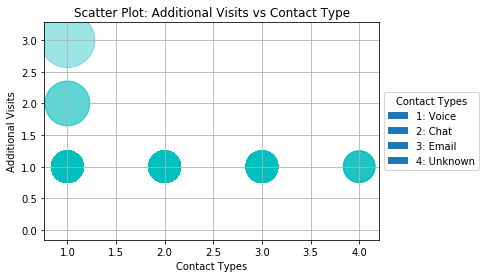

In [335]:
# matplotlib imports 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# plot the additional parts sent vs contact type 
N=50
x = df_contact_type.contact_type
y = df_contact_type.repeat_ct
colors = np.random.rand(N)
# circle sizes based on number of additional visits
area = 1000*df_contact_type.repeat_ct  # 0 to 15 point radii

voice = mpatches.Patch(label='1: Voice')
chat = mpatches.Patch(label='2: Chat')
email = mpatches.Patch(label='3: Email')
unknown = mpatches.Patch(label='4: Unknown')

plt.scatter(x, y, s=area, c='c', alpha=0.15)
plt.legend(handles=[voice, chat, email, unknown])
plt.title('Scatter Plot: Additional Visits vs Contact Type')
plt.legend(handles=[voice, chat, email, unknown], 
           loc='center left', bbox_to_anchor=(1, 0.5), title="Contact Types",fancybox=True)
plt.xlabel('Contact Types')
plt.ylabel('Additional Visits')
plt.grid()
plt.show()

In [336]:
df_visit_contact_type = df.groupby(['contact_type', 'repeat_ct']).repeat_ct.count().unstack()
df_visit_contact_type

repeat_ct,0,1,2,3
contact_type,,,,
1,78185.0,5968.0,6.0,3.0
2,13149.0,1276.0,NaN,NaN
3,1150.0,131.0,NaN,NaN
4,119.0,13.0,NaN,NaN


<strong>Findings</strong>:
* 'df_contact_type' table was assigned numerical values for contact types. 
* 'Scatter Plot: Additional Visits vs Contact Type' was created based on the 'df_contact_type' table. Size of circles were created based on 'repeat_ct'. x-axis represents contact types and y-axis represents the additional visits to fix the reported issue. 
* Based on the plot 'voice' option seems chosen most for additional visits. Pay attention to y values where y = 2 and y =3 and size of circels. 
* This analysis could tell us that 'voice' option could not be a better solution since 'chat' and 'email' seems better options based on this data. 
* Also, look other suggestions to make the 'voice' options a better solution. Another issue could be if the voice option was given to the 'inexperienced' agents to handle the cases. This could be analyzed to see if there is a significant effect on this detail. 

<strong> CASE 4
* We can look into the correlation between diagnostics and repeat_ct to see if diagnostics are helpful to the agents. We can run a hypothesis testing to see if the effect is significant. </strong>

### Correlations: Diagnostics vs Additional Visits

In [337]:
df_diag = df

In [338]:
# Assigned numerical values for type of diagnostics 
df_diag['diagnostics']=df_diag['diagnostics'].str.replace('Not_USED','1')
df_diag['diagnostics']=df_diag['diagnostics'].str.replace('Effective_Usage','2')
df_diag['diagnostics']=df_diag['diagnostics'].str.replace('InEffective_Usage','3')
df_diag['diagnostics']=df_diag['diagnostics'].str.replace('Not_Considered','4')

# somehow 'inEffective_Usage' replace with 'in2' object so replaced it with 3 again
df_diag['diagnostics']=df_diag['diagnostics'].str.replace('In2','3')

In [339]:
# change type from object to numeric to plot
df_diag['diagnostics']=df_diag['diagnostics'].astype(int)

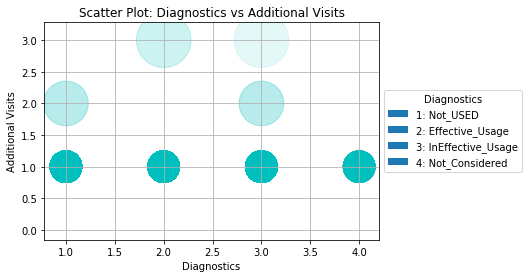

In [340]:
# Scatter Plot for Diagnostics vs Additional Visits

N=50
x = df_diag.diagnostics
y = df_diag.repeat_ct
colors = np.random.rand(N)

# circle size based on additional visits
area = 1000*df_diag.repeat_ct  # 0 to 15 point radii

# lable the diognastics for legend
not_used = mpatches.Patch(label='1: Not_USED')
eff_usag = mpatches.Patch(label='2: Effective_Usage')
ineff_usag = mpatches.Patch(label='3: InEffective_Usage')
not_cons = mpatches.Patch(label='4: Not_Considered')

plt.scatter(x, y, s=area, c='c', alpha=0.1)
plt.legend(handles=[not_used, eff_usag, ineff_usag, not_cons], 
           loc='center left', bbox_to_anchor=(1, 0.5), title="Diagnostics",fancybox=True)
plt.title('Scatter Plot: Diagnostics vs Additional Visits')
plt.xlabel('Diagnostics')
plt.ylabel('Additional Visits')
plt.grid()
plt.show()

<strong>Findings</strong>:
* 'df_diag' table was created by assigning diagnostics values to the numerical values for the scatter plot
* 'Scatter Plot: Diagnostics vs Additional Visits' suggests some correlations but to determine which diagnostics type was effective, I used hypothesis testing between 'not_used' and 'effective_usage' below.

### Hypothesis Testing: To see if the usage of diagnostics effect is significant

* Hypothesis: If diagnostic has effectively been used for each case, there is a significant effect on customer's additional visit

* Null Hypothesis: If diagnostics not effectively been used for each case, there is not a significant effect on customer's additional visit


In [341]:
# Dependencies
import scipy.stats as stats

In [342]:
# Only get diagnostics and repeat_ct columns for testing
df_diag_repeat_ct = df[['diagnostics','repeat_ct']]
df_diag_repeat_ct.head()

,diagnostics,repeat_ct
asst_id,,
0,1,0
1,1,0
2,1,0
3,2,0
4,1,0


In [343]:
# Calculate additional visits mean for diagnostics Not_Used (1) which and Effective_Usage (2)
not_used = df_diag_repeat_ct[df_diag_repeat_ct['diagnostics']==1]
effective_usage = df_diag_repeat_ct[df_diag_repeat_ct['diagnostics']==2]

print(f"mean for diagnostics not used {not_used.repeat_ct.mean()}")
print(f"std for diagnostics not used {not_used.repeat_ct.std()}")
print("-------------")
print(f"mean for diagnostics effectively used {effective_usage.repeat_ct.mean()}")
print(f"std for diagnostics effectively used {effective_usage.repeat_ct.std()}")

mean for diagnostics not used 0.06080189728007115
std for diagnostics not used 0.2391543629971682
-------------
mean for diagnostics effectively used 0.08824302998421883
std for diagnostics effectively used 0.2845800181144111


In [344]:
# function to create scatter and histogram plots comparison 

def gendata():
    not_used_diag = not_used.repeat_ct
    effective_usage_diag = effective_usage.repeat_ct
    
    # scatter plot of data
    plt.subplot(2,1,1)
    plt.scatter(range(len(not_used_diag)), not_used_diag, label='not used diagnostics')
    plt.scatter(range(len(effective_usage_diag)), effective_usage_diag, label='effective usage diagnostics')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # histogram plot of data
    plt.subplot(2,1,2)
    plt.hist(not_used_diag, density=True, alpha=0.7, label='not used diagnostics')
    plt.hist(effective_usage_diag, density=True, alpha=0.7, label='effective usage diagnostics')
    plt.axvline(not_used_diag.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(effective_usage_diag.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    return not_used_diag, effective_usage_diag

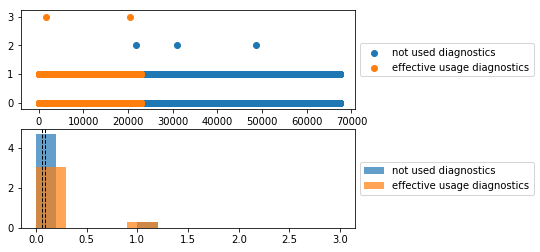

In [345]:
# run the fuction
not_used_diag, effective_usage_diag = gendata()

In [346]:
# Calculate Independent (Two Sample) T-Test
print(stats.ttest_ind(effective_usage.repeat_ct, not_used.repeat_ct, equal_var=False))

Ttest_indResult(statistic=13.085155129188742, pvalue=4.964568799714122e-39)


<strong>Findings</strong>:

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so reject the null hypothesis.

* Hypothesis: If diagnostic has effectively been used for each case, there is a significant effect on customer's additional visit

* That means, if the diagnostics have been effectively used for each case, there is a significant effect on customer's additional visit.

<strong> CASE 5
* We can look into the relation between the time after manufacturing till contact week and topic parts_sent to see what parts are failing when. </strong>

In [347]:
# find the difference in days between contract end and manufacturing time
df['mnfture_to_contact']=df.contract_end_datetime-df.mnfture_datetime
df['mnfture_to_contact_in_days'] = df['mnfture_to_contact'].apply(lambda x: float(x.days))

In [369]:
# we got some negative numbers, filter for positive and zeros
df_no_negative = df.loc[df.mnfture_to_contact_in_days >= 0,:]

In [370]:
df_mnfture_to_contract = pd.DataFrame(df_no_negative.groupby('parts_sent').mnfture_to_contact_in_days.mean()).\
            sort_values('mnfture_to_contact_in_days', ascending=True)
df_mnfture_to_contract.head(10)

,mnfture_to_contact_in_days
parts_sent,
"Miscellaneous(2), LCD Panel(6)",147.000000
"Printer, Base Unit",168.000000
"Miscellaneous(2), Battery (Other)(2)",231.000000
"Miscellaneous(2), LCD Panel(2), Hard Drive",256.666667
"Speaker(2), Motherboard, Miscellaneous, Heatsink, Documentation",259.000000
"Motherboard(5), Miscellaneous, Cables(2)",266.000000
"Miscellaneous(2), Adapter, AC(5)",294.000000
"Miscellaneous, LCD Panel(2)",294.000000
"LCD, Adapter, AC",296.333333


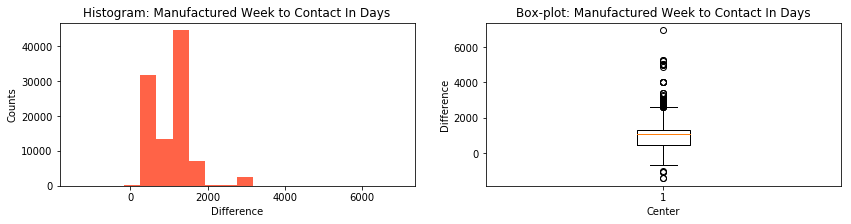

In [368]:
# change the type from object to numerical for mnfture_wk
df['mnfture_to_contact_in_days']=df['mnfture_to_contact_in_days'].astype(float)

# histogram
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,3))

ax1.hist(df.mnfture_to_contact_in_days, bins=20, color='tomato')
ax1.set_title('Histogram: Manufactured Week to Contact In Days')
ax1.set_xlabel('Difference')
ax1.set_ylabel('Counts')

# box-plot
ax2.boxplot(df['mnfture_to_contact_in_days'])
ax2.set_title('Box-plot: Manufactured Week to Contact In Days')
ax2.set_xlabel('Center')
ax2.set_ylabel('Difference')

plt.show()

In [377]:
# Manufactured Week to Contact In Days Related Statistical Analysis (box-plot)

print('mean {}'.format(df['mnfture_to_contact_in_days'].mean()))
print('median {} '.format(df['mnfture_to_contact_in_days'].median()))
print('max {}'.format(df['mnfture_to_contact_in_days'].max()))
print('min {}'.format(df['mnfture_to_contact_in_days'].min()))
print('Range {}'.format((df['mnfture_to_contact_in_days'].max())-(df['mnfture_to_contact_in_days'].min())))
print('25th Perc {}'.format(df['mnfture_to_contact_in_days'].quantile(0.25)))
print('50th Perc {}'.format(df['mnfture_to_contact_in_days'].quantile(0.5)))
print('75th Perc {}'.format(df['mnfture_to_contact_in_days'].quantile(0.75)))
print('Variance {}'.format(df['mnfture_to_contact_in_days'].var()))
print('Standard Deviation {}'.format(df['mnfture_to_contact_in_days'].std()))

mean 1025.59821
median 1099.0 
max 6958.0
min -1421.0
Range 8379.0
25th Perc 462.0
50th Perc 1099.0
75th Perc 1316.0
Variance 295769.5940509479
Standard Deviation 543.8470318489823


In [375]:
print('skewness for Manufactured Week to Contact In Days is {0:2f} and the data is right tailed'.format(df['mnfture_to_contact_in_days'].skew()))

skewness for Manufactured Week to Contact In Days is 1.007186 and the data is right tailed


<strong>Findings</strong>:
* 'df_mnfture_to_contract' table show top 10 failing parts based on the average numbers of manufacturing week until contact week differences. We need to ignore the negative numbers because it would not make sense if the contact week for a part is before part is manufactured.

* 'Histogram: Manufactured Week to Contact In Days' gives some idea for different ranges for manufacture week to contact week. As seen there are some extreme outliers. 
* 'Box-plot: Manufactured Week to Contact In Days' gives some statistical analysis of quartiles and extreme outliers. 
* This suggests that, based on this data, the failing parts varies. 
* 'df_mnfture_to_contract' tables helps us to determine which parts needs to be focused on for the future operations. 

<strong> CASE 6
* We can look into if people are contacting the support right before their warranty expires. </strong>

In [373]:
# find the difference in days between contact week and contract end time

df['contact_for_contract_end']=df.contact_week_datetime - df.contract_end_datetime
df['contact_for_contract_end'] = df['contact_for_contract_end'].apply(lambda x: float(x.days))
df = df.sort_values('contact_for_contract_end', ascending=True)

value =round((len(df.loc[(df['contact_for_contract_end']<=0) & \
                         (df['contact_for_contract_end']>-365) ,:])/len(df))*100,0)
print(f"{value}% of people who has their contract ending withing a year contacted to the tech support")

36.0% of people who has their contract ending withing a year contacted to the tech support


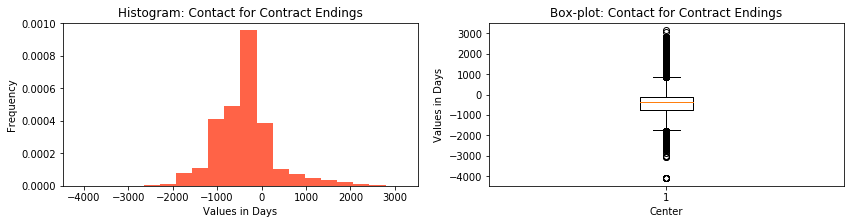

In [379]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,3))

# histogram for contacting the tech support before the contract ends
# there is a spike for contacting to the tech support right before the contract ends
ax1.hist(df.contact_for_contract_end, density=True, bins=20, color='tomato')
ax1.set_title('Histogram: Contact for Contract Endings')
ax1.set_xlabel('Values in Days')
ax1.set_ylabel('Frequency')


# box plot suggest that we have outliers 
# and there are some extreme outlier can be ivestigated further
ax2.boxplot(df['contact_for_contract_end'])
ax2.set_title('Box-plot: Contact for Contract Endings')
ax2.set_xlabel('Center')
ax2.set_ylabel('Values in Days')

plt.show()

In [376]:
# Contact for Contract Endings In Days Related Statistical Analysis (box-plot)

print('mean {}'.format(df['contact_for_contract_end'].mean()))
print('median {} '.format(df['contact_for_contract_end'].median()))
print('max {}'.format(df['contact_for_contract_end'].max()))
print('min {}'.format(df['contact_for_contract_end'].min()))
print('Range {}'.format((df['contact_for_contract_end'].max())-(df['contact_for_contract_end'].min())))
print('25th Perc {}'.format(df['contact_for_contract_end'].quantile(0.25)))
print('50th Perc {}'.format(df['contact_for_contract_end'].quantile(0.5)))
print('75th Perc {}'.format(df['contact_for_contract_end'].quantile(0.75)))
print('Variance {}'.format(df['contact_for_contract_end'].var()))
print('Standard Deviation {}'.format(df['contact_for_contract_end'].std()))

mean -371.23954
median -357.0 
max 3157.0
min -4109.0
Range 7266.0
25th Perc -770.0
50th Perc -357.0
75th Perc -112.0
Variance 462088.3991446068
Standard Deviation 679.7708431115642


In [378]:
print('skewness for contact for contract ending in days is {0:2f} and the data is right tailed'.format(df.contact_for_contract_end.skew()))

skewness for contact for contract ending in days is 0.913443 and the data is right tailed


<strong>Findings</strong>:
* 'Histogram: Contact for Contract Endings' and 'Box-plot: Contact for Contract Endings' we can say that this data is well shaped with a spike on the left of 'zero' and with a mean value -371. The data got some extreme min and max values and it is bell shaped closed to the zero. It is suggesting that people are contacting to the tech support when their contract is close to be expired. 
* Also from the 'Histogram: Contact for Contract Endings' there is a spike on the left side of 'zero' suggesting that more contacts are made before the contracts expire.  
* Based on this data and with help of math, 36% of people are contacting the tech support withing a year before their warranty expires.

<strong> CASE 7 
* We can look into the correlation between topic_category and repeat_ct to see if some problem types especially lead to additional visits.


In [381]:
df_topic_cat_repeat = df.groupby(['topic_category','repeat_ct']).repeat_ct.count().sort_values(0, ascending=True).unstack()
df_topic_cat_repeat=df_topic_cat_repeat.sort_values(1,ascending=False).groupby('topic_category').head()
df_topic_cat_repeat.head()

repeat_ct,0,1,2,3
topic_category,,,,
Unknown,30528.0,2555.0,1.0,NaN
Booting,13517.0,1825.0,1.0,NaN
LCD/Monitor,4902.0,549.0,NaN,1.0
Call Logs,4551.0,280.0,4.0,2.0
Hard Drive,3324.0,210.0,NaN,NaN


<strong> Findings </strong>
* 'df_topic_cat_repeat' table suggests that booting, LCD/Monitor, Call Logs, Hard Drive are the top 4 (ignoring Unknown) for repeat_ct = 1 for additional visits to fix the problems. 
* As a suggestions, these topics could be most to be focused for the future operations. 